## Sampling Methods

In [1]:
"""
    Module to sample the input space

    This module is part of the SAFE Toolbox by F. Pianosi, F. Sarrazin and
    T. Wagener at Bristol University (2015).
    SAFE is provided without any warranty and for non-commercial use only.
    For more details, see the Licence file included in the root directory
    of this distribution.
    For any comment and feedback, or to discuss a Licence agreement for
    commercial use, please contact: francesca.pianosi@bristol.ac.uk
    For details on how to cite SAFE in your publication, please see:
    https://safetoolbox.github.io

    Package version: SAFEpython_v0.1.1

"""

# from __future__ import division, absolute_import, print_function

import math
# from warnings import warn
import numpy as np
from numpy.matlib import repmat
import scipy.stats as st

from safepython.lhcube import lhcube, lhcube_extend

def AAT_sampling(samp_strat, M, distr_fun, distr_par, N, nrep=5):

    """ Generates a sample X composed of N random samples of M uncorrelated
    variables.

    Usage:
        X = sampling.AAT_sampling(samp_strat, M, distr_fun, distr_par, N, nrep=5)

    Input:
    samp_strat = sampling strategy                                     - string
                 Options: 'rsu': random uniform
                          'lhs': latin hypercube
             M = number of variables                                  - integer
     distr_fun = probability distribution function for ech input
                     - function (eg: 'scipy.stats.uniform') if all
                       variables have the same pdf
                     - list of M functions (e.g.:
                       ['scipy.stats.uniform','scipy.stats.norm']) otherwise
     distr_par = parameters of the probability distribution function
                     - list of parameters if all input variables have the same
                     - list of M lists otherwise
             N = number of samples                                    - integer

    Optional input:
          nrep = number of replicate to select the maximin            - integer
                 hypercube(default value: 5)

    Output:
             X = matrix of samples                        - numpy.ndarray (N,M)
                 Each row is a point in the input space.
                 In contrast to OAT_sampling, rows are not sorted in any
                 specific order, and all elements in a row usually
                 differ from the elements in the following row.

    Supported probability distribution function :

         scipy.stats.beta        (Beta)
         scipy.stats.binom       (Binomial)
         scipy.stats.chi2        (Chisquare)
         scipy.stats.dweibull    (Double Weibull)
         scipy.stats.expon       (Exponential)
         scipy.stats.f           (F)
         scipy.stats.gamma       (Gamma)
         scipy.stats.genextreme  (Generalized Extreme Value)
         scipy.stats.genpareto   (Generalized Pareto)
         scipy.stats.geom        (Geometric)
         scipy.stats.hypergeom   (Hypergeometric)
         scipy.stats.lognorm     (Lognormal)
         scipy.stats.nbinom      (Negative Binomial)
         scipy.stats.ncf         (Noncentral F)
         scipy.stats.nct         (Noncentral t)
         scipy.stats.ncx2        (Noncentral Chi-square)
         scipy.stats.norm        (Normal)
         scipy.stats.poisson     (Poisson)
         scipy.stats.randint     (Discrete Uniform)
         scipy.stats.rayleigh    (Rayleigh)
         scipy.stats.t           (T)
         scipy.stats.uniform     (Uniform)
         scipy.stats.weibull_max (Weibull maximum)
         scipy.stats.weibull_min (Weibull minimum)

    Examples:

    import scipy.stats as st
    import matplotlib.pyplot as plt

    from safepython.sampling import AAT_sampling

    # Example 1: 2 inputs, both from Unif[0,3]
    N = 1000
    M = 2
    distr_fun = st.uniform
    distr_par = [0, 3]
    samp_strat = 'lhs'
    X = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)

    # Plot results:
    plt.figure()
    plt.plot(X[:, 0], X[:, 1], '.k')
    plt.xlabel('x_1')
    plt.ylabel('x_2')

    # Example 2: 2 inputs, one from Unif[0,3], one from Unif[1,5]
    distr_fun = st.uniform
    distr_par = [[0, 3], [1, 4]]
    X = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)
    # (use above code to plot results)

    # Example 3: 2 inputs, one from Unif[0,3], one from discrete, uniform in [1,5]
    distr_fun = [st.uniform, st.randint]
    distr_par = [[0, 3], [1, 6]]
    X = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)

    # Example 4: investigate the difference between 'rsu' and 'lhs':
    N = 20
    X1 = AAT_sampling('rsu', 2, st.uniform, [0, 1], N)
    X2 = AAT_sampling('lhs', 2, st.uniform,[0, 1], N)
    plt.figure()
    plt.subplot(121)
    plt.plot(X1[:, 0],X1[:, 1], 'ok')
    plt.title('Random Uniform')
    plt.subplot(122)
    plt.plot(X2[:, 0],X2[:, 1], 'ok')
    plt.title('Latin Hypercube')

    Note: In sampling.AAT_sampling, the function lhcube.lhcube is used to derive
    latin hypercube sampling (L126). Alternatively, the python package pyDOE
    (pyDOE.lhs) could be used to perform latin hypercube sampling.

    This function is part of the SAFE Toolbox by F. Pianosi, F. Sarrazin
    and T. Wagener at Bristol University (2015).
    SAFE is provided without any warranty and for non-commercial use only.
    For more details, see the Licence file included in the root directory
    of this distribution.
    For any comment and feedback, or to discuss a Licence agreement for
    commercial use, please contact: francesca.pianosi@bristol.ac.uk
    For details on how to cite SAFE in your publication, please see:
    https://www.safetoolbox.info """

    ###########################################################################
    # Check inputs
    ###########################################################################

    if not isinstance(samp_strat, str):
        raise ValueError('"samp_strat" must be a string.')

    if not isinstance(M, (int, np.int8, np.int16, np.int32, np.int64)):
        raise ValueError('"M" must be scalar and integer.')
    if M <= 0:
        raise ValueError('"M" must be positive.')

    if callable(distr_fun):
        distr_fun = [distr_fun] * M
    elif isinstance(distr_fun, list):
        if len(distr_fun) != M:
            raise ValueError('If "distr_fun" is a list, it must have M components.')
    else:
        raise ValueError('"distr_fun" must be a list of functions or a function.')

    if isinstance(distr_par, list):
        if all(isinstance(i, float) or isinstance(i, int) for i in distr_par):
            distr_par = [distr_par] * M
        elif not all(isinstance(i, list) for i in distr_par):
            raise ValueError('"distr_par" be a list of M lists of parameters' +
                             'or a list of parameters is all input have the same.')
    else:
        raise ValueError('Wrong data type for input "distr_par".')

    if not isinstance(N, (int, np.int8, np.int16, np.int32, np.int64)):
        raise ValueError('"N" must be scalar and integer.')
    if N <= 0:
        raise ValueError('"N" must be positive.')

    ###########################################################################
    # Uniformly sample the unit square
    ###########################################################################
    if samp_strat == 'rsu':
        X = np.random.random((N, M))
    elif samp_strat == 'lhs':
        X, _ = lhcube(N, M, nrep)
    else:
        raise ValueError("""Sampling_strategy should be either ''rsu'' or ''lhs'""")

    ###########################################################################
    # Map back into the specified distribution by inverting the CDF
    ###########################################################################
    for i in range(M):

        pars = distr_par[i]
        num_par = len(pars)
        name = distr_fun[i]

        if name in [st.chi2, st.expon, st.geom, st.poisson, st.rayleigh,
                    st.t,st.weibull_max, st.weibull_min]:
            if num_par != 1:
                raise ValueError('Input ' + '%d' % (i+1)+ ': Number of PDF' +
                                 'parameters not consistent with PDF type')
            else:
                X[:, i] = name.ppf(X[:, i], pars)

        elif name in [st.beta, st.binom, st.f, st.gamma, st.lognorm, st.nbinom,
                      st.nct, st.ncx2, st.norm, st.uniform, st.randint]:
            if num_par != 2:
                raise ValueError('Input ' + '%d' % (i+1)+ ': Number of PDF' +
                                 'parameters not consistent with PDF type')
            else:
                X[:, i] = name.ppf(X[:, i], pars[0], pars[1])

        elif name in [st.genextreme, st.genpareto, st.hypergeom, st.ncf]:
            if num_par != 3:
                raise ValueError('Input ' + '%d' % (i+1)+ ': Number of PDF' +
                                 'parameters not consistent with PDF type')
            else:
                X[:, i] = name.ppf(X[:, i], pars[0], pars[1], pars[2])
        else:
            raise ValueError('Input ' + '%d' % (i+1)+ ': Unknown PDF type')

    return X

def AAT_sampling_extend(X, distr_fun, distr_par, Next, nrep=10):

    """This function create an expanded sample 'Xext' starting from a sample
    'X' and using latin hypercube and the maximin criterion.

    Usage:
    Xext = sampling.AAT_sampling_extend(X, distr_fun, distr_par, Next, n_rep=10)

    Input:
            X = initial sample                            - numpy.ndarray(N,M)
    distr_fun = probability distribution function for ech input
                     - string (eg: 'unif') if all variables have the same pdf
                     - list of M strings (e.g.: ['unif','norm']) otherwise
    distr_par = parameters of the probability distribution function
                      - list of parameters if all input variables have the same
                      - list of M lists otherwise
         Next = new dimension of the sample (must be > N)             - integer
         nrep = number of replicate to select the maximin             - integer
                hypercube(default value: 10)

    Output:
          Xext = expanded sample                        - numpy.ndarray(Next,M)

    See also sampling.AAT_sampling.

    This function is part of the SAFE Toolbox by F. Pianosi, F. Sarrazin
    and T. Wagener at Bristol University (2015).
    SAFE is provided without any warranty and for non-commercial use only.
    For more details, see the Licence file included in the root directory
    of this distribution.
    For any comment and feedback, or to discuss a Licence agreement for
    commercial use, please contact: francesca.pianosi@bristol.ac.uk
    For details on how to cite SAFE in your publication, please see:
    https://www.safetoolbox.info"""

    ###########################################################################
    # Check inputs
    ###########################################################################
    if not isinstance(X, np.ndarray):
        raise ValueError('"X" must be a numpy.array.')
    if X.dtype.kind != 'f' and X.dtype.kind != 'i' and X.dtype.kind != 'u':
        raise ValueError('"X" must contain floats or integers.')

    Nx = X.shape
    if len(Nx) != 2:
        raise ValueError('"X" must be an array of size (N,M).')
    N = Nx[0]
    M = Nx[1]

    if callable(distr_fun):
        distr_fun = [distr_fun] * M
    elif isinstance(distr_fun, list):
        if len(distr_fun) != M:
            raise ValueError('If "distr_fun" is a list, it must have M components.')
    else:
        raise ValueError('"distr_fun" must be a list of functions or a function.')

    if isinstance(distr_par, list):
        if all(isinstance(i, float) or isinstance(i, int) for i in distr_par):
            distr_par = [distr_par] * M
        elif not all(isinstance(i, list) for i in distr_par):
            raise ValueError('"distr_par" be a list of M lists of parameters' +
                             'or a list of parameters is all input have the same.')
    else:
        raise ValueError('Wrong data type for input "distr_par".')

    if not isinstance(Next, (int, np.int8, np.int16, np.int32, np.int64)):
        raise ValueError('"N" must be scalar and integer.')
    if Next <= N:
        raise ValueError('"Next" must be larger than N.')

    ###########################################################################
    # Check optional inputs
    ##########################################################################
    if not isinstance(nrep, (int, np.int8, np.int16, np.int32, np.int64)):
        raise ValueError('"nrep" must be scalar and integer.')
    if nrep <= 0:
        raise ValueError('"nrep" must be positive.')

    ###########################################################################
    # Map back the original sample into the uniform unit square
    ##########################################################################
    U = np.nan * np.ones((N, M)) # initialization

    for i in range(M):

        pars = distr_par[i]
        num_par = len(pars)
        name = distr_fun[i]


        if name in [st.chi2, st.expon, st.geom, st.poisson, st.rayleigh,
                    st.t,st.weibull_max, st.weibull_min]:
            if num_par != 1:
                raise ValueError('Input ' + '%d' % (i+1)+ ': Number of PDF' +
                                 'parameters not consistent with PDF type')
            else:
                U[:, i] = name.cdf(X[:, i], pars)

        elif name in [st.beta, st.binom, st.f, st.gamma, st.lognorm, st.nbinom,
                      st.nct, st.ncx2, st.norm, st.uniform, st.randint]:
            if num_par != 2:
                raise ValueError('Input ' + '%d' % (i+1)+ ': Number of PDF' +
                                 'parameters not consistent with PDF type')
            else:
                U[:, i] = name.cdf(X[:, i], pars[0], pars[1])

        elif name in [st.genextreme, st.genpareto, st.hypergeom, st.ncf]:
            if num_par != 3:
                raise ValueError('Input ' + '%d' % (i+1)+ ': Number of PDF' +
                                 'parameters not consistent with PDF type')
            else:
                U[:, i] = name.cdf(X[:, i], pars[0], pars[1], pars[2])
        else:
            raise ValueError('Input ' + '%d' % (i+1)+ ': Unknown PDF type')

    ###########################################################################
    # Add samples in the unit square
    ###########################################################################
    Uext = lhcube_extend(U, Next, nrep=nrep)

    ###########################################################################
    # Map back into the specified distribution by inverting the CDF
    ###########################################################################
    Xext = np.nan * np.ones((Next, M)) # initialization

    for i in range(M):

        pars = distr_par[i]
        num_par = len(pars)
        name = distr_fun[i]

        if name in [st.chi2, st.expon, st.geom, st.poisson, st.rayleigh,
                    st.t,st.weibull_max, st.weibull_min]:
            if num_par != 1:
                raise ValueError('Input ' + '%d' % (i+1)+ ': Number of PDF' +
                                 'parameters not consistent with PDF type')
            else:
                Xext[:, i] = name.ppf(Uext[:, i], pars)

        elif name in [st.beta, st.binom, st.f, st.gamma, st.lognorm, st.nbinom,
                      st.nct, st.ncx2, st.norm, st.uniform, st.randint]:
            if num_par != 2:
                raise ValueError('Input ' + '%d' % (i+1)+ ': Number of PDF' +
                                 'parameters not consistent with PDF type')
            else:
                Xext[:, i] = name.ppf(Uext[:, i], pars[0], pars[1])

        elif name in [st.genextreme, st.genpareto, st.hypergeom, st.ncf]:
            if num_par != 3:
                raise ValueError('Input ' + '%d' % (i+1)+ ': Number of PDF' +
                                 'parameters not consistent with PDF type')
            else:
                Xext[:, i] = name.ppf(Uext[:, i], pars[0], pars[1], pars[2])
        else:
            raise ValueError('Input ' + '%d' % (i+1)+ ': Unknown PDF type')

    return Xext


def OAT_sampling(r, M, distr_fun, distr_par, samp_strat, des_type, nrep=5):

    """Build a matrix X of input samples to be used for the Elementary Effects
    Test, using a One-At-the-Time sampling strategy as described in
    Campolongo et al. (2011).

    Usage:
    X = sampling.OAT_sampling(r, M, distr_fun, distr_par, samp_strat,
                              des_type, nrep=5)

    Input:
              r = number of elementary effects                        - integer
              M = number of inputs                                    - integer
      distr_fun = probability distribution function for each input
                  - string (eg: 'unif') if all variables have the same pdf
                  - list of M strings (e.g. '[unif','norm']) otherwise
                  See help of AAT_sampling to check supported PDF types
     distr_par = parameters of the probability distribution function
                 - list of parameters if all input variables have the same
                 - list of M lists otherwise

    samp_strat = sampling strategy                                     - string
                 Options: 'rsu': random uniform
                          'lhs': latin hypercube
      des_type = design type                                           - string
                 Options: 'trajectory','radial'

    Optional input:
          nrep = number of replicate to select the maximin            - integer
                 hypercube(default value: 5)

    Output:
             X = array of sampling datapoints where - numpy.ndarray (r*(M+1),M)
                 EEs must be computed.
                 Each row is a point in the input
                 space. Rows are sorted in 'r'
                 blocks, each including 'M+1' rows.
                 Within each block, points (rows)
                 differ in one component at the
                 time. Thus, each block can be used
                 to compute one Elementary Effect
                 (EE_i) for each model input
                 ( = 1,...,M).

    See also sampling.AAT_sampling for supported probability distribution
    function.

    Examples:

    import scipy.stats as st
    import matplotlib.pyplot as plt
    from safepython.sampling import OAT_sampling

    # Example 1: 2 inputs, both from Unif[0,3]
    r = 10
    M = 2
    distr_fun = st.uniform
    distr_par = [0, 3]
    samp_strat = 'lhs'
    des_type = 'radial'
    X = OAT_sampling(r, M, distr_fun, distr_par, samp_strat, des_type)

    # Plot results:
    clrs = plt.cm.jet(np.linspace(0, 1, r))
    plt.figure()
    j = 0
    for k in range(r): # loop over trajectories
        idx = np.arange(j, j+M+1)
        j = j+M+1
        plt.plot(X[idx, 0], X[idx, 1], 'o:k', markerfacecolor=clrs[k])
    plt.xlabel('x1')
    plt.ylabel('x2')

    # Example 2: 2 inputs, one from Unif[0,3], one from Unif[1,5]
    distr_fun = st.uniform
    distr_par = [[0, 3], [1, 4]]
    X = OAT_sampling(r ,M, distr_fun, distr_par, samp_strat, des_type)
    # (use above code to plot results)

    # Example 3: 2 inputs, one from Unif[0,3], one from discrete, uniform in [1,5]
    distr_fun = [st.uniform, st.randint]
    distr_par = [[0, 3], [1, 6]]
    X  = OAT_sampling(r, M, distr_fun, distr_par, samp_strat, des_type)

    References:

    Campolongo F., Saltelli, A. and J. Cariboni (2011), From screening to
    quantitative sensitivity analysis. A unified approach, Computer Physics
    Communications, 182(4), 978-988.

    This function is part of the SAFE Toolbox by F. Pianosi, F. Sarrazin
    and T. Wagener at Bristol University (2015).
    SAFE is provided without any warranty and for non-commercial use only.
    For more details, see the Licence file included in the root directory
    of this distribution.
    For any comment and feedback, or to discuss a Licence agreement for
    commercial use, please contact: francesca.pianosi@bristol.ac.uk
    For details on how to cite SAFE in your publication, please see:
    https://www.safetoolbox.info"""

    ###########################################################################
    # Check inputs
    ###########################################################################
    if not isinstance(r, (int, np.int8, np.int16, np.int32, np.int64)):
        raise ValueError('"r" must be scalar and integer.')
    if r <= 0:
        raise ValueError('"r" must be positive.')

    if not isinstance(M, (int, np.int8, np.int16, np.int32, np.int64)):
        raise ValueError('"M" must be scalar and integer.')
    if M <= 0:
        raise ValueError('"M" must be positive.')

    if not isinstance(des_type, str):
        raise ValueError('"des_type" must be a string.')

    # 'distr_fun', 'distr_par', 'samp_strat' will be checked later by the
    # sampling.AAT_sampling function

    ###########################################################################
    # Perform sampling
    ###########################################################################

    # Sample the array of r baseline and auxiliary points 'AB':
    AB = AAT_sampling(samp_strat, M, distr_fun, distr_par, 2*r, nrep)

    X = np.nan * np.ones((r*(M+1), M)) # initialize sampling points
    k = 0

    for i in range(r): # loop over the elementary effects
    # Sample datapoints:
        a = AB[i*2, :] # baseline point, shape (M, )
        b = AB[i*2+1, :] # auxiliary point, shape (M, )
        for j in range(M): # loop over inputs
            if a[j] == b[j]:
                if distr_fun[j] == st.randint: # resample this component if the
                                             # distribution is random uniform
                    while a[j] == b[j]:
                        tmp = AAT_sampling(samp_strat, M, distr_fun, distr_par, 2)
                        b[j] = tmp[1, j]
                        warn('b[i=%d, j=%d] was randomly changed ' % (i, j) +
                             'not to overlap with a[i=%d, j=%d] \n'% (i, j))
                else: # just print a warning message
                    warn('b[i=%d, j=%d] and a[i=%d, j=%d] are the same! \n'% (i, j, i, j))

        X[k, :] = a
        k = k + 1
        x = repmat(a, M, 1) # shape(M, M)
        if des_type == 'radial':
            for j in range(M):
                x[j, j] = b[j]
                X[k, :] = x[j, :]
                if abs(X[k, j] - X[k-1, j] == 0):
                    warn('X(%d, %d) and X(%d, %d) are equal\n' % (k, j, k-1, j))
                k = k + 1

        elif des_type == 'trajectory':
            for j in range(M):
                x[j, 0:j+1] = b[0:j+1]
                X[k, :] = x[j, :]
                if abs(X[k, j] - X[k-1, j] == 0):
                    warn('X(%d, %d) and X(%d, %d) are equal\n' % (k, j, k-1, j))
                k = k + 1
        else:
            raise ValueError('"des_type" must be one among ["radial", "trajectory"]')

    return X


def Morris_sampling(r, xmin, xmax, L):

    """Build a array X of input samples to be used for the Elementary Effects
    Test, using the One-At-the-Time sampling strategy originally proposed by
    Morris (1991). It implicitely assumes that all the inputs be uncorrelated
    and drawn from a continuous, uniform distribution function.

    Usage:
        X = sampling.Morris_sampling(r, xmin, xmax, L)

    Input:
       r = number of elementary effects             - integer
    xmin = lower bounds of input ranges             - list (M elements)
    xmax = upper bounds of input ranges             - list (M elements)
       L = number of levels in the sampling grid    - integer (even)

    Output:
       X = matrix of sampling datapoints where EE   - numpy.ndarray(r*(M+1),M))
           must becomputed. Each row of X is a
           point in the input space. Rows are sorted
           in 'r' blocks, each including 'M+1' rows.
           Within each block, points (rows) differ
           in one component at the time. Thus, each
           block can be used to compute one
           Elementary Effect (EE_i) for each model
           input (i=1,...,M).

    References:

    Morris, M.D. (1991), Factorial sampling plans for preliminary
    computational experiments, Technometrics, 33(2).

    This function is part of the SAFE Toolbox by F. Pianosi, F. Sarrazin
    and T. Wagener at Bristol University (2015).
    SAFE is provided without any warranty and for non-commercial use only.
    For more details, see the Licence file included in the root directory
    of this distribution.
    For any comment and feedback, or to discuss a Licence agreement for
    commercial use, please contact: francesca.pianosi@bristol.ac.uk
    For details on how to cite SAFE in your publication, please see:
    https://www.safetoolbox.info"""

    ###########################################################################
    # Check inputs
    ###########################################################################

    if not isinstance(r, (int, np.int8, np.int16, np.int32, np.int64)):
        raise ValueError('"r" must be scalar and integer.')
    if r <= 0:
        raise ValueError('"r" must be positive.')

    if not isinstance(xmin, list):
        raise ValueError('"xmin" must be a list with M elements')
    if not all(isinstance(i, float) or isinstance(i, int) for i in xmin):
        raise ValueError('Elements in "xmin" must be int or float.')
    if not isinstance(xmax, list):
        raise ValueError('"xmin" must be a list with M elements')
    if not all(isinstance(i, float) or isinstance(i, int) for i in xmax):
        raise ValueError('Elements in "xmax" must be int or float.')
    M = len(xmin)
    if len(xmax) != M:
        raise ValueError('"xmin" and "xmax" must have the same number of elements.')
    xmin = np.array(xmin)
    xmax = np.array(xmax)
    Dr = xmax - xmin
    if not all(i >= 0 for i in Dr):
        raise ValueError('all components of "xmax" must be higher than'+
                         'the corresponding ones in "xmin"')

    if not isinstance(L, (int, np.int8, np.int16, np.int32, np.int64)):
        raise ValueError('"L" must be scalar and integer.')
    if L <= 0:
        raise ValueError('"L" must be positive.')
    if L % 2 != 0:
        L = math.ceil(L/2)*2
        warn('"L" must be even!\n Using L = %d instead of user-defined value\n' % L)

    ###########################################################################
    # Perform sampling
    ###########################################################################

    X = np.nan * np.ones((r*(M+1), M)) # sampling points

    for i in range(r): # loop on elementary effects
        # Sample datapoints in the unit square:
        Bstar = Morris_orientation_matrix(M, L) #  shape (M+1,M)
        # Resort to original ranges:
        Bstar = repmat(xmin, M+1, 1) + Bstar*repmat(Dr, M+1, 1)
        X[i*(M+1):(i+1)*(M+1), :] = Bstar

    return X

def Morris_orientation_matrix(k, p):

    """
    Usage:
        Bstar = sampling.Morris_orientation_matrix(k, p)

        k = number of inputs                             - integer
        p = number of levels                             - integer (even)
    Bstar = array of (k+1) datapoints in the             - numpy.ndarray(k+1,k)
            k-dimensional input space
            (to be used for computing one Elementary
            Effect for each of the 'k' inputs)

    # Example in two-dimensional space (k=2):

    import numpy as np
    import matplotlib.pyplot as plt
    from safepython.sampling import Morris_orientation_matrix

    p = 4
    k = 2
    plt.figure()
    Bstar = Morris_orientation_matrix(k, p)
    plt. plot(Bstar[:, 0], Bstar[:, 1], '.r-')
    # if you want to generate more datapoints:
    Bstar = Morris_orientation_matrix(k, p)
    plt. plot(Bstar[:, 0], Bstar[:, 1], 'xb-')
    Bstar = Morris_orientation_matrix(k, p)
    plt. plot(Bstar[:, 0], Bstar[:, 1], 'oc-')
    Bstar = Morris_orientation_matrix(k, p)
    plt. plot(Bstar[:, 0], Bstar[:, 1], 'sm-')
    plt.xticks(np.arange(0, 1+1/(p-1), 1/(p-1)))
    plt.yticks(np.arange(0, 1+1/(p-1), 1/(p-1)))
    plt.xlim((-0.1, 1.1))
    plt.ylim((-0.1, 1.1))
    plt.grid(b=True)
    """

    ###########################################################################
    # Check inputs
    ###########################################################################
    if not isinstance(k, (int, np.int8, np.int16, np.int32, np.int64)):
        raise ValueError('"k" must be scalar and integer.')
    if k <= 0:
        raise ValueError('"k" must be positive.')

    if not isinstance(p, (int, np.int8, np.int16, np.int32, np.int64)):
        raise ValueError('"p" must be scalar and integer.')
    if p <= 0:
        raise ValueError('"p" must be positive.')
    if p % 2 != 0:
        p = math.ceil(p/2)*2
        warn('"p" must be even!\n Using p = %d instead of user-defined value\n' % p)

    ###########################################################################
    # Determine orientation matrix
    ###########################################################################

    Delta = p/(2*(p-1))
    # sampling matrix:
    B = np.tril(np.ones((k+1, k)), -1) # shape (k+1,k)

    # Create diagonal matrix with [-1,1] elements
    tmp = np.random.randint(0, 2, size=(k,)) # random numbers from [0,1]
    tmp[tmp == 0] = -1 # random numbers from [-1,1]
    D = np.diag(tmp)

    # Create base value vector
    In = np.nan * np.ones((1, int(p/2)))
    for i in range(int(p/2)):
        In[0, i] = i/(p-1)

    tmp = np.random.randint(len(In[0, :]), size=(k,))
    x = In[:, tmp]

    # Create random permutation matrix
    P = np.eye(k)
    idx = np.random.choice(k, size=(k,), replace=False)
    P = P[idx, :]

    Jmk = np.ones((k+1, k))
    Jm1 = np.ones((k+1, 1))

    # Create a random orientation of B:
    #Bstar = (Jm1@x + Delta/2*((2*B-Jmk)@D + Jmk))@P # does not work for python 2
    Bstar = np.matmul(np.matmul(Jm1, x) + Delta/2*(np.matmul(2*B-Jmk,D) + Jmk), P)

    return Bstar

def OAT_sampling_extend(X, r_ext, distr_fun, distr_par, des_type, nrep=10):

    """This function create an expanded sample 'Xext' starting from a sample
    'X' to be used for the Elementary Effects Test. One-At-the-Time sampling
    strategy as described in Campolongo et al.(2011) is used. The matrix of
    baseline and auxiliary points is built using latin hypercube and the
    maximin criterion.

    Usage:

    Xext, Xnew = \
     sampling.OAT_sampling_extend(X,r_ext,M,distr_fun,distr_par,des_type)
    Xext, Xnew = \
     sampling.OAT_sampling_extend(X,r_ext,M,distr_fun,distr_par,des_type,n_rep)

      Input:
              X = initial sample build as described - numpy.ndarray (r*(M+1),M)
                 in OAT_sampling.
          r_ext = new number of elementary effects                    - integer
      distr_fun = probability distribution function for each input
                  - string (eg: 'unif') if all variables have the same pdf
                  - list of M strings (e.g. '[unif','norm']) otherwise
                  See help of AAT_sampling to check supported PDF types
     distr_par = parameters of the probability distribution function
                 - list of parameters if all input variables have the same
                 - list of M lists otherwise
      des_type = design type                                           - string
                 Options: 'trajectory','radial'

    Optional input:
          nrep = number of replicate to select the maximin hypercube  - integer
                 (default value: 10)

    Output:
         Xext = expanded sample                 - numpy.ndarray (r_ext*(M+1),M)
         Xnew = newly added samples             - numpy.ndarray (r_new*(M+1),M)
                (where    Xext = [ X; Xnew ]
                          r_ext = r + r_new )

    This function is part of the SAFE Toolbox by F. Pianosi, F. Sarrazin
    and T. Wagener at Bristol University (2015).
    SAFE is provided without any warranty and for non-commercial use only.
    For more details, see the Licence file included in the root directory
    of this distribution.
    For any comment and feedback, or to discuss a Licence agreement for
    commercial use, please contact: francesca.pianosi@bristol.ac.uk
    For details on how to cite SAFE in your publication, please see:
    https://www.safetoolbox.info"""

    ###########################################################################
    # Check inputs
    ###########################################################################
    if not isinstance(X, np.ndarray):
        raise ValueError('"X" must be a numpy.array.')
    if X.dtype.kind != 'f' and X.dtype.kind != 'i' and X.dtype.kind != 'u':
        raise ValueError('"X" must contain floats or integers.')

    Nx = X.shape
    if len(Nx) != 2:
        raise ValueError('"X" must be an array of size (N,M).')
    N = Nx[0]
    M = Nx[1]

    if N % (M+1) != 0:
        raise ValueError('"X" must have r*(M+1) lines and M columns')
    r = int(N/(M+1))

    if not isinstance(r_ext, (int, np.int8, np.int16, np.int32, np.int64)):
        raise ValueError('"r_ext" must be scalar and integer.')
    if r_ext <= 0:
        raise ValueError('"r_ext" must be positive.')

    if not isinstance(des_type, str):
        raise ValueError('"des_type" must be a string.')

    # 'distr_fun', 'distr_par', 'samp_strat', 'r_ext' and 'n_rep' will be
    # checked later by the AAT_sampling function

    ###########################################################################
    # Compute the new matrix of baseline and auxiliary points
    ###########################################################################
    ABold = np.nan * np.ones((2*r, M)) # old matrix of baseline and auxiliary points in sample X
    if des_type == 'radial':
        for i in range(r):
            ABold[2*i, :] = X[i*(M+1), :]
            for j in range(M):
                ABold[2*i+1, j] = X[i*(M+1)+j+1, j]

    elif des_type == 'trajectory':
        for i in range(r):
            ABold[2*i, :] = X[i*(M+1), :]
            ABold[2*i+1, :] = X[(i+1)*(M+1)-1, :]
    else:
        raise ValueError('"des_type" must be one among ["radial","trajectory"]')

    ABext = AAT_sampling_extend(ABold, distr_fun, distr_par, 2*r_ext, nrep)
    # new matrix of baseline and auxiliary points for extended sample Xext

    ABnew = ABext[2*r:2*r_ext, :]
    r_new = r_ext-r

    ###########################################################################
    # Add the intermediate points to the extension of the sample
    ###########################################################################
    Xnew = np.nan * np.ones((r_new*(M+1), M)) # initialize sampling points
    k = 0

    for i in range(r_new): # loop over the elementary effects
    # Sample datapoints:
        a = ABnew[i*2, :] # baseline point, shape (M, )
        b = ABnew[i*2+1, :] # auxiliary point, shape (M, )
        for j in range(M): # loop over inputs
            if a[j] == b[j]:
                if distr_fun[j] == 'randint': # resample this component if the
                                             # distribution is random uniform
                    while a[j] == b[j]:
                        tmp = AAT_sampling('lhs', M, distr_fun, distr_par, 2)
                        b[j] = tmp[1, j]
                        warn('b[i=%d, j=%d] was randomly changed ' % (i, j) +
                             'not to overlap with a[i=%d, j=%d] \n'% (i, j))
                else: # just print a warning message
                    warn('b[i=%d, j=%d] and a[i=%d, j=%d] are the same! \n'% (i, j, i, j))

        Xnew[k, :] = a
        k = k + 1
        x = repmat(a, M, 1) # shape(M, M)
        if des_type == 'radial':
            for j in range(M):
                x[j, j] = b[j]
                Xnew[k, :] = x[j, :]
                if abs(Xnew[k, j] - Xnew[k-1, j] == 0):
                    warn('Xnew(%d, %d) and Xnew(%d, %d) are equal\n' % (k, j, k-1, j))
                k = k + 1

        elif des_type == 'trajectory':
            for j in range(M):
                x[j, 0:j+1] = b[0:j+1]
                Xnew[k, :] = x[j, :]
                if abs(Xnew[k, j] - Xnew[k-1, j] == 0):
                    warn('Xnew(%d, %d) and Xnew(%d, %d) are equal\n' % (k, j, k-1, j))
                k = k + 1

    Xext = np.concatenate((X, Xnew), axis=0)

    return Xext, Xnew


## Module to compute the Ishigami-Homma function

In [2]:
"""
    Module to compute the Ishigami-Homma function

    This module is part of the SAFE Toolbox by F. Pianosi, F. Sarrazin and
    T. Wagener at Bristol University (2015).
    SAFE is provided without any warranty and for non-commercial use only.
    For more details, see the Licence file included in the root directory
    of this distribution.
    For any comment and feedback, or to discuss a Licence agreement for
    commercial use, please contact: francesca.pianosi@bristol.ac.uk
    For details on how to cite SAFE in your publication, please see:
    https://safetoolbox.github.io

    Package version: SAFEpython_v0.1.1

    References:

     Saltelli et al. (2008) Global Sensitivity Analysis, The Primer, Wiley.
"""

# from __future__ import division, absolute_import, print_function

import numpy as np
# from numba import jit

# @jit
def ishigami_homma_function(x):
    """Implements the Ishigami-Homma function, a standard benchmark function in
    the Sensitivity Analysis literature (see for instance Eq. (4.34) in
    Saltelli et al. (2008)).

    Usage:
    y, V, Si_ex, STi_ex= ishigami_homma_function(x)

    Input:
         x = vector of inputs x[0],x[1],x[2]               - numpy.ndarray(3, )
        x(i) ~ Unif(-pi,+pi) for all i
    Output:
         y = output                                        - numpy.ndarray(1,)
         V = output variance (*)                           - numpy.ndarray(1,)
     Si_ex = first-order sensitivity indices (*)           - numpy.ndarray(3, )
    STi_ex = total-order sensitivity indices (*)           - numpy.ndarray(3, )

    (*) = exact value computed analytically

    REFERENCES

    Saltelli et al. (2008) Global Sensitivity Analysis, The Primer, Wiley.

    This function is part of the SAFE Toolbox by F. Pianosi, F. Sarrazin
    and T. Wagener at Bristol University (2015).
    SAFE is provided without any warranty and for non-commercial use only.
    For more details, see the Licence file included in the root directory
    of this distribution.
    For any comment and feedback, or to discuss a Licence agreement for
    commercial use, please contact: francesca.pianosi@bristol.ac.uk
    For details on how to cite SAFE in your publication, please see:
    https://www.safetoolbox.info"""

    a=2
    b=1
    y = np.array(np.sin(x[0]) + a*(np.sin(x[1]))**2 + b*(x[2])**4*np.sin(x[0]))

    # By model definition, we should get:
    # VARy = VAR(Y) = 1/2 + a^2/8 + b*pi^4/5 + b^2*pi^8/18
    # V1 = VAR(E(Y|X1)) = 1/2 + b*pi^4/5 + b^2*pi^8/50
    # V2 = VAR(E(Y|X2)) = a^2/8
    # V3 = VAR(E(Y|X3)) = 0
    # V13 = VAR(E(Y|X1,X3)) = b^2*pi^4/18 - b^2*pi^8/50
    # V12 = V23 = V123 = 0
    # and thus:
    # ST1 = S1 + S13
    # ST2 = S2
    # ST3 = S13

    Si_ex = np.nan * np.ones((3,))
    STi_ex = np.nan * np.ones((3,))
    V  = np.array(1/2 + a**2/8 + b*np.pi**4/5 + b**2*np.pi**8/18)
    Si_ex[0] = (1/2 + b*np.pi**4/5 + b**2*np.pi**8/50)/V
    Si_ex[1] = a**2/8 / V
    Si_ex[2] = 0
    STi_ex[0] = Si_ex[0] + (b**2*np.pi**8/18 - b**2*np.pi**8/50)/V
    STi_ex[1] = Si_ex[1]
    STi_ex[2] = (b**2*np.pi**8/18 - b**2*np.pi**8/50)/V

    return y, V, Si_ex, STi_ex


## Module to execute the model

In [3]:
"""
    Module to execute the model

    This module is part of the SAFE Toolbox by F. Pianosi, F. Sarrazin and
    T. Wagener at Bristol University (2015).
    SAFE is provided without any warranty and for non-commercial use only.
    For more details, see the Licence file included in the root directory
    of this distribution.
    For any comment and feedback, or to discuss a Licence agreement for
    commercial use, please contact: francesca.pianosi@bristol.ac.uk
    For details on how to cite SAFE in your publication, please see:
    https://safetoolbox.github.io

    Package version: SAFEpython_v0.1.1
"""

# from __future__ import division, absolute_import, print_function

import numpy as np

def model_execution(fun_test, X, *args, ExtraArgOut=False):

    """Executes the model coded in the matlab function 'fun_test' against
    each sample input vector in matrix X, and returns the associated output
    vectors (in matrix Y).

    Usage:
    Y = model_execution.model_execution(fun_test, X, *args, ExtraArgOut=False)

    Input:
     fun_test = function implementing the model.           - python function
                The first output argument of
                'fun_test' must be a numpy.ndarray of
                shape (P, ), (1,P) or (P,1).
           X = matrix of N input sample                    - numpy.ndarray(N,M)
              (each input sample has M components)

    Optional input:
        *args = extra arguments needed to execute 'fun_test'

    ExtraArgOut = specifies if extra output arguments must - boolean
                  be returned beyond Y in case
                  'fun_test' provides extra output
                  arguments.
                  (default: False, i.e. no extra output
                  arguments are returned)

    Output:
            Y = vector (NxP) of associated output samples, - numpy.ndarray(N,P)
                P being the number of model outputs
                associated to each sampled input
                combination (corresponds to the first
                output argument of 'fun_test')

    Optional output:
       argout = extra output arguments provided by         - tuple
                'fun_test' if ExtraArgOut is True. argout
                is a tuple and each element of argout
                corresponds to an output argument of fun_test.

    NOTES:
    1) If the 'fun_test' function requires other arguments besides 'X',
    or produce other output besides 'Y', they can be passed as optional
    arguments after 'X' and recovered as optional output after 'Y'.
    2) The assignment of the 'argout' variable must be customised by the user
    for the specific case study (see L141-145)

    Example:

    import numpy as np
    from safepython.model_execution import model_execution
    from safepython.sobol_g import sobol_g_function

    fun_test = sobol_g_function
    X =  np.random.random((3, 4))
    a = np.ones((4,))
    Y = model_execution(fun_test, X, a) # Or:
    Y, tmp = model_execution(fun_test, X, a, ExtraArgOut=True)
    V = tmp[0]
    Si_ex = tmp[1]

    This function is part of the SAFE Toolbox by F. Pianosi, F. Sarrazin
    and T. Wagener at Bristol University (2015).
    SAFE is provided without any warranty and for non-commercial use only.
    For more details, see the Licence file included in the root directory
    of this distribution.
    For any comment and feedback, or to discuss a Licence agreement for
    commercial use, please contact: francesca.pianosi@bristol.ac.uk
    For details on how to cite SAFE in your publication, please see:
    https://www.safetoolbox.info"""

    ###########################################################################
    # Check inputs
    ###########################################################################
    if not isinstance(X, np.ndarray):
        raise ValueError('"X" must be a numpy.array.')
    if X.dtype.kind != 'f' and X.dtype.kind != 'i' and X.dtype.kind != 'u':
        raise ValueError('"X" must contain floats or integers.')
    Nx = X.shape
    N = Nx[0]
    if len(Nx) != 2:
        raise ValueError('"X" must have at least two rows.')
    if not isinstance(ExtraArgOut, bool):
        raise ValueError('"ExtraArgOut" must be scalar and boolean.')

    ###########################################################################
    # Recover the type and shapes of the output arguments of my_fun
    ###########################################################################

    # Perform one model run to determine P (number output to be saved ) and the
    # number of extra arguments given by 'fun_test':
    tmp = fun_test(X[0, :], *args)  # modified

    if isinstance(tmp, tuple): # my_fun provides extra output arguments
        # Recover the total number of extra arguments:
        NumExtraArgOut = len(tmp) - 1 # number of extra arguments
        # Check format of first argument of the function
        if not isinstance(tmp[0], np.ndarray):
            raise ValueError('the first output argument returned by ' +
                             '"fun_test" must be a numpy.ndarray')
        if tmp[0].dtype.kind != 'f' and tmp[0].dtype.kind != 'i' and \
        tmp[0].dtype.kind != 'u':
            raise ValueError('the first output argument returned by ' +
                             '"fun_test" must contains float or integers.')
        N1 = tmp[0].shape
        if len(N1) > 2:
            raise ValueError('the first output argument returned by ' +
                             '"fun_test" must be of shape (P, ), (P,1) or (1,P).')
        elif len(N1) == 2:
            if N1[0] != 1 and N1[1] != 1:
                raise ValueError('the first output argument returned by ' +
                                 '"fun_test" must be of shape (P, ), (P,1) or (1,P).')
        P = len(tmp[0].flatten())

    else: # no extra arguments
        NumExtraArgOut = 0
        if not isinstance(tmp, np.ndarray):
            raise ValueError('the first output argument returned by ' +
                             '"fun_test" must be a numpy.ndarray')
        if tmp.dtype.kind != 'f' and tmp.dtype.kind != 'i' and tmp.dtype.kind != 'u':
            raise ValueError('the first output argument returned by '  +
                             '"fun_test" must contains float or integers.')
        N1 = tmp.shape
        if len(N1) > 2:
            raise ValueError('the first output argument returned by ' +
                             '"fun_test" must be of shape (P, ), (P,1) or (1,P).')
        elif len(N1) == 2:
            if N1[0] != 1 and N1[1] != 1:
                raise ValueError('the first output argument returned by ' +
                                 '"fun_test" must be of shape (P, ), (P,1) or (1,P).')
        P = len(tmp.flatten())

    # Perform the model runs

    Y = np.nan * np.ones((N, P)) # variable initialization
    for j in range(N):
        if NumExtraArgOut == 0:
            Y[j, :] = fun_test(X[j, :], *args).flatten()
        else: # save extra output arguments in a tuple
            tmp = fun_test(X[j, :], *args)
            Y[j, :] = tmp[0].flatten()
            # Assign extra output argument (these lines should be customised by
            # the user for the specific case study):
            argout = ()
            for i in range(NumExtraArgOut):
                argout = argout + (tmp[i+1],)

    # Determine the output arguments to be returned
    if ExtraArgOut and NumExtraArgOut != 0: # Return extra arguments
        return Y, argout
    else:
        return Y


## This script provides an application example

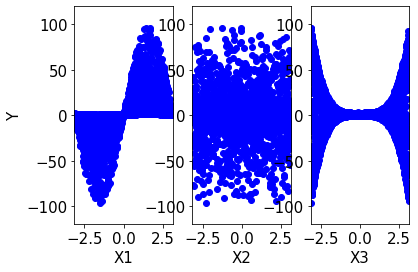

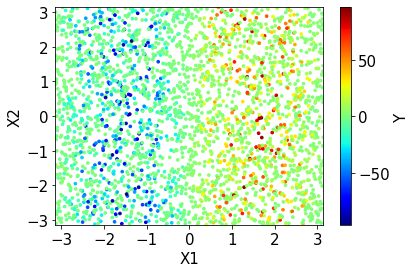

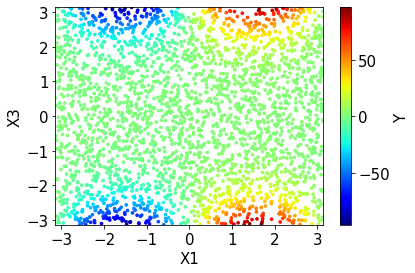

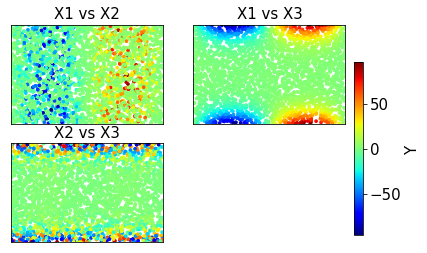

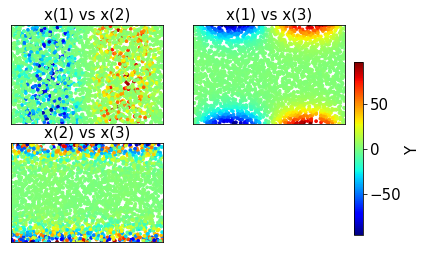

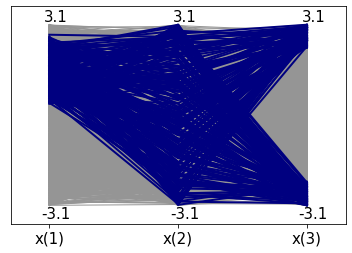

In [4]:
"""
This script provides an application example of how to use several
visualization tools (scatter plots, 2D coloured scatter plots, parallel
coordinate plots) to learn about sensitivity.
The application example is the Hishigami-Homma function, which is a
standard benchmark function in the Sensitivity Analysis literature.
(see help of function 'ishigami_homma.ishigami_homma_function' for more details
and references).

This script was prepared by Fanny Sarrazin, 2019
fanny.sarrazin@ufz.de
"""

#%% Step 1: (import python modules)

# from __future__ import division, absolute_import, print_function

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# from safepython.model_execution import model_execution
import safepython.plot_functions as pf # module to visualize the results
# from safepython.sampling import AAT_sampling

# from safepython.ishigami_homma import ishigami_homma_function

#%% Step 2 (setup the model)

# Number of uncertain parameters subject to SA:
M = 3

# Parameter ranges
xmin = -np.pi
xmax = np.pi
# Parameter distributions
distr_fun = st.uniform # uniform distribution
# The shape parameters of the uniform distribution are the lower limit and the
# difference between lower and upper limits:
distr_par = [xmin, xmax - xmin]

# Define output:
fun_test = ishigami_homma_function

#%% Step 3 (sampling and model evaluation)
samp_strat = 'lhs' # Latin Hypercube
N = 3000  #  Number of samples
X = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)
Y = model_execution(fun_test, X)

#%% Step 4 (Scatter plots)
# Use scatter plots of inputs againts output to visually assess
# direct effects:
plt.figure(); pf.scatter_plots(X, Y)
plt.show()
# Use coloured scatter plots of one input against another on to assess
# interactions:
i1 = 0
i2 = 1
plt.figure(); pf.scatter_plots_col(X, Y, i1, i2) # plot x[i1] against x[i2]
plt.show()
# Change i2:
i2 = 2
plt.figure(); pf.scatter_plots_col(X, Y, i1, i2)
plt.show()
# Put all possible combinations of i1,i2 into one figure:
pf.scatter_plots_interaction(X, Y)
plt.show()
# Customize titles:
pf.scatter_plots_interaction(X, Y, X_Labels=['x(1)', 'x(2)', 'x(3)'])
plt.show()

#%% Step 5 (Parallel Coordinate Plot)

# Use Parallel Coordinate Plot to find patterns of input combinations
# mapping into specific output condition
idx = Y > 30 # output condition to be highlighted
plt.figure(); pf.parcoor(X, X_Labels=['x(1)', 'x(2)', 'x(3)'], idx=idx)
plt.show()


## EET module

In [5]:
"""
    Module to perform the Elementary Effect Test (EET) or method of Morris

    This module is part of the SAFE Toolbox by F. Pianosi, F. Sarrazin and
    T. Wagener at Bristol University (2015).
    SAFE is provided without any warranty and for non-commercial use only.
    For more details, see the Licence file included in the root directory
    of this distribution.
    For any comment and feedback, or to discuss a Licence agreement for
    commercial use, please contact: francesca.pianosi@bristol.ac.uk
    For details on how to cite SAFE in your publication, please see:
    https://safetoolbox.github.io

    Package version: SAFEpython_v0.1.1

    References:
    Morris, M.D. (1991), Factorial sampling plans for preliminary
    computational experiments, Technometrics, 33(2).

    Saltelli, A., et al. (2008), Global Sensitivity Analysis, The Primer,
    Wiley.

    Campolongo, F., Cariboni, J., Saltelli, A. (2007), An effective
    screening design for sensitivity analysis of large models. Environ. Model.
    Softw. 22 (10), 1509-1518.
"""
# from __future__ import division, absolute_import, print_function

from warnings import warn
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt

def EET_indices(r, xmin, xmax, X, Y, design_type, Nboot=0):

    """Compute the sensitivity indices according to the Elementary Effects Test
    (Saltelli, 2008) or 'method of Morris' (Morris, 1991).
    These are: the mean (mi) of the Elementary Effects (EEs) associated to
    input 'i', which measures the input influence; and the standard deviation
    (sigma) of the EEs, which measures its level of interactions with other
    inputs.
    For the mean EE, we use the version suggested by Campolongo et al.
    (2007), where absolute values of the EEs are used (this is to avoid that
    EEs with opposite sign would cancel each other out).

    Usage:
     mi, sigma, EE = EET.EET_indices(r, xmin, xmax, X, Y, design_type, Nboot=0)


    Input:
              r = number of sampling points          - scalar
           xmin = lower bounds of input ranges       - list (M elements)
           xmax = upper bounds of input ranges       - list (M elements)
              X = matrix of sampling datapoints      - numpy.ndarray(r*(M+1),M)
                  where EE must be computed
              Y = associated output values           - numpy.ndarray(r*(M+1), )
                                                  or - numpy.ndarray(r*(M+1),1)
      des_type = design type                         - string
                 Options: 'trajectory', 'radial'

    Optional input:
          Nboot = number of resamples used for       - integer
                  boostrapping(if not specified:
                  Nboot=0, i.e. no bootstrapping)
    Output:
             mi = mean of absolute elementary       if Nboot <= 1:
                  effects estimated for each        - numpy.ndarray (M, )
                  bootstrap resample when           if Nboot > 1:
                  bootstrapping is used (Nboot>1)   - numpy.ndarray (Nboot,M)
         sigma = standard deviation of elementary   if Nboot <= 1:
                  effects estimated for each        - numpy.ndarray (M, )
                  bootstrap resample when           if Nboot > 1:
                  bootstrapping is used (Nboot>1)   - numpy.ndarray (Nboot,M)
         EE = matrix of 'r' elementary effects      - numpy.ndarray(r,M)

    NOTE: If the vector Y includes any NaN values, the function will
    identify them and exclude them from further computation. A Warning message
    about the number of discarded NaN elements (and hence the actual number
    of samples used for estimating mi and sigma) will be displayed.

    REFERENCES:

    Morris, M.D. (1991), Factorial sampling plans for preliminary
    computational experiments, Technometrics, 33(2).

    Saltelli, A., et al. (2008), Global Sensitivity Analysis, The Primer,
    Wiley.

    Campolongo, F., Cariboni, J., Saltelli, A. (2007), An effective
    screening design for sensitivity analysis of large models. Environ. Model.
    Softw. 22 (10), 1509-1518.

    This function is part of the SAFE Toolbox by F. Pianosi, F. Sarrazin
    and T. Wagener at Bristol University (2015).
    SAFE is provided without any warranty and for non-commercial use only.
    For more details, see the Licence file included in the root directory
    of this distribution.
    For any comment and feedback, or to discuss a Licence agreement for
    commercial use, please contact: francesca.pianosi@bristol.ac.uk
    For details on how to cite SAFE in your publication, please see:
    https://www.safetoolbox.info"""

    ###########################################################################
    # Check inputs
    ###########################################################################
    if not isinstance(r, (int, np.int8, np.int16, np.int32, np.int64)):
        raise ValueError('"r" must be scalar and integer.')
    if r <= 0:
        raise ValueError('"r" must be positive.')

    if not isinstance(xmin, list):
        raise ValueError('"xmin" must be a list with M elements')
    if not all(isinstance(i, float) or isinstance(i, int) for i in xmin):
        raise ValueError('Elements in "xmin" must be int or float.')
    if not isinstance(xmax, list):
        raise ValueError('"xmin" must be a list with M elements')
    if not all(isinstance(i, float) or isinstance(i, int) for i in xmax):
        raise ValueError('Elements in "xmax" must be int or float.')
    M = len(xmin)
    if len(xmax) != M:
        raise ValueError('"xmin" and "xmax" must have the same number of elements.')
    xmin = np.array(xmin)
    xmax = np.array(xmax)
    Dr = xmax - xmin
    if not all(i >= 0 for i in Dr):
        raise ValueError('all components of "xmax" must be higher than the' +
                         'corresponding ones in "xmin"')

    if not isinstance(X, np.ndarray):
        raise ValueError('"X" must be a numpy.array.')
    if X.dtype.kind != 'f' and X.dtype.kind != 'i' and X.dtype.kind != 'u':
        raise ValueError('"X" must contain floats or integers.')
    if not isinstance(Y, np.ndarray):
        raise ValueError('"Y" must be a numpy.array.')
    if Y.dtype.kind != 'f' and Y.dtype.kind != 'i' and Y.dtype.kind != 'u':
        raise ValueError('"Y" must contain floats or integers.')

    Nx = X.shape
    Ny = Y.shape

    if len(Nx) != 2:
        raise ValueError('input "X" must have shape (N, M)')
    if Nx[1] != M:
        raise ValueError('input "X" must have M columns')
    if Nx[0] != r*(M+1):
        raise ValueError('input "X" must have r*(M+1) rows')

    if len(Ny) == 2:
        if Ny[1] != 1:
            raise ValueError('"Y" must be of size (N, ) or (N,1).')
        Y = Y.flatten()
    elif len(Ny) != 1:
        raise ValueError('"Y" must be of size (N, ) or (N,1).')
    if Ny[0] != Nx[0]:
        raise ValueError('The number of elements in "Y" must be equal to the number of rows in X.')

    ###########################################################################
    # Check optional inputs
    ###########################################################################
    if not isinstance(Nboot, (int, np.int8, np.int16, np.int32, np.int64)):
        raise ValueError('"Nboot" must be scalar and integer.')
    if Nboot < 0:
        raise ValueError('"Nboot" must be positive.')

    ###########################################################################
    # Compute elementary effects
    ###########################################################################
    EE = np.nan * np.ones((r, M)) # array of elementary effects
    k = 0
    ki = 0 # index of the first element of the block for the current elementary effect

    for i in range(r):
        for j in range(M):

            if design_type == 'radial': # radial design: EE is the difference
            # between output at one point in the i-th block and output at
            # the 1st point in the block
                EE[i, j] = (Y[k+1]-Y[ki]) / (X[k+1, j]-X[ki, j]) * Dr[j]

            elif design_type == 'trajectory': #  trajectory design: EE is the difference
            # between output at one point in the i-th block and output at
            # the previous point in the block (the "block" is indeed a
            # trajectory in the input space composed of points that
            # differ in one component at the time)
                idx = abs(X[k+1, :]-X[k, :]) > 0
                # if using 'morris' sampling, the points in the block may not
                # be in the proper order, i.e. each point in the block differs
                # from the previous/next one by one component but we don't know
                # which one; this is here computed and saved in 'idx'
                if sum(idx) == 0:
                    raise ValueError('X[%d,:] and X[%d,:] are equal' % (k, k+1))
                if sum(idx) > 1:
                    raise ValueError('X[%d,:] and X[%d,:] differ in more ' % (k, k+1) +
                                     'than one component')
                EE[i, idx] = (Y[k+1]-Y[k]) / (X[k+1, idx]-X[k, idx]) * Dr[idx]
            else:
                raise ValueError('"design_type" must be one among ["radial",  "trajectory"]')

            k = k + 1

        k = k + 1
        ki = k

    ###########################################################################
    # Compute mean and standard deviation
    ###########################################################################

    if Nboot > 1:
        bootsize = r # size of bootstrap resamples
        B = np.random.randint(r, size=(bootsize, Nboot))

        mi = np.nan * np.ones((Nboot, M))
        sigma = np.nan * np.ones((Nboot, M))
        idx_EE = np.nan * np.ones((Nboot, M))

        for n in range(Nboot):
            mi[n, :], sigma[n, :], idx_EE[n, :] = compute_indices(EE[B[:, n], :])

        # Print to screen a warning message if any NAN was found in Y
        if np.sum(np.isnan(Y)):
            warn('\n%d NaNs were found in Y' % np.sum(np.isnan(Y)))

            str_EE = "\nX%d: %1.0f" % (1, np.mean(idx_EE[:, 0]))
            for i in range(1, M):
                str_EE = str_EE + "\nX%d: %1.0f" % (i+1, np.mean(idx_EE[:, i]))

            print('\nAverage number of samples that could be used to evaluate mean ' +
                  'and standard deviation of elementary effects is:')
            print(str_EE)
            print('\n')

    else:
        mi, sigma, idx_EE = compute_indices(EE)

       # Print to screen a warning message if any NAN was found in Y
        if np.sum(np.isnan(Y)):
            warn('\n%d NaNs were found in Y' % np.sum(np.isnan(Y)))

            str_EE = "\nX%d: %1.0f" % (1, idx_EE[0])
            for i in range(1, M):
                str_EE = str_EE + "\nX%d: %1.0f" % (i+1, idx_EE[i])

            print('\nNumber of samples that could be used to evaluate mean ' +
                  'and standard deviation of elementary effects is:')
            print(str_EE)
            print('\n')

    return mi, sigma, EE


def compute_indices(EE):

    """This function computes the sensitivity indices according to the
    Elementary Effects Test (Saltelli, 2008) or 'method of Morris'
    (Morris, 1991) for ONE sample/bootstrap resample.

    This function is called internally in EET.EET_indices.

    Usage:
        mi, sigma, idx_EE = EET.compute_indices(EE)

    Input:
        EE = matrix of 'r' elementary effects (EEs)        - numpy.ndarray(r,M)

    Output:
        mi = mean of absolute elementary                   - numpy.ndarray(M, )
             effects
     sigma = standard deviation of the                     - numpy.ndarray(M, )
                  elementary effects
    idx_EE = array that indicates the number of NaNs       - numpy.ndarray(M, )
             for each of the M columns of EE.

    NOTE: If the vector Y includes any NaN values, the function will
    identify them and exclude them from further computation.

    For reference and further details see help of EET.EET_indices.

    This function is part of the SAFE Toolbox by F. Pianosi, F. Sarrazin
    and T. Wagener at Bristol University (2015).
    SAFE is provided without any warranty and for non-commercial use only.
    For more details, see the Licence file included in the root directory
    of this distribution.
    For any comment and feedback, or to discuss a Licence agreement for
    commercial use, please contact: francesca.pianosi@bristol.ac.uk
    For details on how to cite SAFE in your publication, please see:
    https://www.safetoolbox.info/"""

    idx_EE = np.sum(~np.isnan(EE), axis=0) # find number of NaN in EE
    mi = np.nanmean(abs(EE), axis=0) # mean absolute value of EE (excluding NaNs)
    sigma = np.nanstd(EE, axis=0) # std of EE (excluding NaNs)

    return mi, sigma, idx_EE


def EET_convergence(EE, rr, Nboot=0):

    """Compute mean and standard deviation of Elementary Effects
    using sub-samples of the original sample 'EE' of increasing size
    (see help of EET.EET_indices for more details about the EET and references)

    Usage:
        mi, sigma = EET.EET_convergence(EE, rr, Nboot=0)

    Input:
       EE = matrix of 'r' elementary effects (EEs)         - numpy.ndarray(r,M)
       rr = reduced number of EEs at which indices will be - numpy.ndarray(R, )
           estimated (must be a vector of positive integer
           values not exceeding 'r')

    Optional input:
    Nboot = number of resamples used for boostrapping      - integer
            (if not specified: Nboot=0, i.e. no
            bootstrapping)

    Output:
      mi = mean of absolute EEs at different sample sizes if Nboot <= 1:
           When bootstrapping is used (i.e. Nboot>1),     - numpy.ndarray (R,M)
           mi[j] is a numpy.ndarray(Nboot,M) of the       if Nboot > 1:
           Nboot estimates of 'spread' for the jth        - list(R elements)
           sample size
   sigma = mean of absolute EEs at different sample sizes if Nboot <= 1:
           When bootstrapping is used (i.e. Nboot>1),     - numpy.ndarray (R,M)
           sigma[j] is a numpy.ndarray(Nboot,M) of the    if Nboot > 1:
           Nboot estimates of 'spread' for the jth        - list(R elements)
           sample size

    NOTE: If the vector EE includes any NaN values, the function will
    identify them and exclude them from further computation. A Warning message
    about the number of discarded NaN elements (and hence the actual number
    of samples used for estimating mi and sigma) will be displayed.

    This function is part of the SAFE Toolbox by F. Pianosi, F. Sarrazin
    and T. Wagener at Bristol University (2015).
    SAFE is provided without any warranty and for non-commercial use only.
    For more details, see the Licence file included in the root directory
    of this distribution.
    For any comment and feedback, or to discuss a Licence agreement for
    commercial use, please contact: francesca.pianosi@bristol.ac.uk
    For details on how to cite SAFE in your publication, please see:
    https://www.safetoolbox.info/"""

    ###########################################################################
    # Check inputs
    ###########################################################################
    if not isinstance(EE, np.ndarray):
        raise ValueError('"EE" must be a numpy.array.')
    if EE.dtype.kind != 'f' and EE.dtype.kind != 'i' and EE.dtype.kind != 'u':
        raise ValueError('"EE" must contain floats or integers.')

    NE = EE.shape
    r = NE[0]
    M = NE[1]

    if not isinstance(rr, np.ndarray):
        raise ValueError('"rr" must be a numpy.array.')
    if rr.dtype.kind != 'i':
        raise ValueError('"rr" must contain integers.')
    if any(i < 0 for i in np.diff(rr)):
        raise ValueError('elements in "rr" must be sorted in ascending order')
    if any(i < 0 for i in rr):
        raise ValueError('elements in "rr" must be positive')
    if rr[-1] > r:
        raise ValueError('Maximum value in "rr" must not exceed r = %d' % r)
    Nr = rr.shape
    if len(Nr) > 1:
        raise ValueError('"rr" must be of shape (R,).')

    ###########################################################################
    # Check optional inputs
    ###########################################################################
    if not isinstance(Nboot, (int, np.int8, np.int16, np.int32, np.int64)):
        raise ValueError('"Nboot" must be scalar and integer.')
    if Nboot < 0:
        raise ValueError('"Nboot" must be positive.')

    ###########################################################################
    # Compute indices
    ###########################################################################

    R = len(rr)
    # Intialise variables
    if Nboot > 1:
        mi = [np.nan]*R
        sigma = [np.nan]*R
    else:
        mi = np.nan * np.ones((R, M))
        sigma = np.nan * np.ones((R, M))

    for j in range(R): # loop on sample sizes
        # Option 1: randomly select a subset of NN(j) without replacement
        # (which is our recommendation in particular for small sample size)
        replace = False
        # Option 2: resample with replacement
        #replace = True
        idx = np.random.choice(np.arange(0, r, 1), size=(rr[j], ), replace=replace)

        EEj = EE[idx,:] # extract the selected sample

        if Nboot > 1:
            bootsize = rr[j] # size of bootstrap resamples
            B = np.random.randint(rr[j], size=(bootsize, Nboot))
            mi[j] = np.nan * np.ones((Nboot, M))
            sigma[j] = np.nan * np.ones((Nboot, M))
            idx_EEj = np.nan * np.ones((Nboot, M))

            for n in range(Nboot):
                mi[j][n, :], sigma[j][n, :], idx_EEj[n, :] = \
                compute_indices(EEj[B[:, n], :])

            # Print to screen a warning message if any NAN was found in EE
            if np.sum(np.isnan(EE)):
                warn('\n%d NaNs were found in EE' % np.sum(np.isnan(EE)))

                str_EE = "\nX%d: %1.0f" % (1, np.mean(idx_EEj[:,0]))
                for i in range(1, M):
                    str_EE = str_EE + "\nX%d: %1.0f" % (i+1, np.mean(idx_EEj[:,i]))

                print('\nAverage number of samples that could be used to evaluate mean ' +
                      'and standard deviation of elementary effects is:')
                print(str_EE)
                print('\n')

        else:
            mi[j, :], sigma[j, :], idx_EEj = compute_indices(EEj)

             # Print to screen a warning message if any NAN was found in EE
            if np.sum(np.isnan(EE)):
                warn('\n%d NaNs were found in EE' % np.sum(np.isnan(EE)))

                str_EE = "\nX%d: %1.0f" % (1, idx_EEj[0])
                for i in range(1, M):
                    str_EE = str_EE + "\nX%d: %1.0f" % (i+1, idx_EEj[i])

                    print('\nNumber of samples that could be used to evaluate mean ' +
                          'and standard deviation of elementary effects is:')
                    print(str_EE)
                    print('\n')

    return mi, sigma

def EET_plot(mi, sigma, labelinput=[], mi_lb=np.array([]),
             mi_ub=np.array([]), sigma_lb=np.array([]), sigma_ub=np.array([])):

    """ Plot the sensitivity indices computed by the Elementary Effects Test -
    mean (mi) of the EEs on the horizontal axis and standard deviation (sigma)
    of the EEs on the vertical axis.
    (see help of EET_indices for more details about the EET and references)

    Usage:

    EET.EET_plot(mi, sigma)
    EET.EET_plot(mi, sigma, labelinput)
    EET.EET_plot(mi, sigma, labelinput=[], mi_lb=np.array([]),
                 mi_ub=np.array([]), sigma_lb=np.array([]), sigma_ub=np.array([]))

    Inputs:
            mi = mean of the elementary effects             - numpy.ndarray(M,)
         sigma = standard deviation of the elementary       - numpy.ndarray(M,)
                 effects

    Optional inputs:
    labelinput = strings for the x-axis labels              - list(M)
         mi_lb = lower bound of 'mi'                        - numpy.ndarray(M,)
         mi_ub = upper bound of 'mi'                        - numpy.ndarray(M,)
      sigma_lb = lower bound of 'sigma'                     - numpy.ndarray(M,)
      sigma_ub = upper bound of 'sigma'                     - numpy.ndarray(M,)

    This function is part of the SAFE Toolbox by F. Pianosi, F. Sarrazin
    and T. Wagener at Bristol University (2015).
    SAFE is provided without any warranty and for non-commercial use only.
    For more details, see the Licence file included in the root directory
    of this distribution.
    For any comment and feedback, or to discuss a Licence agreement for
    commercial use, please contact: francesca.pianosi@bristol.ac.uk
    For details on how to cite SAFE in your publication, please see:
    https://www.safetoolbox.info/"""

    # Options for the graphic
    pltfont = {'fontname': 'DejaVu Sans', 'fontsize': 15} # font for axes
    pltfont_leg = {'family': 'DejaVu Sans', 'size': 15} # font for legend
    ms = 10 # Marker size

    # Options for the legend
    sorting = 1 # If 1, inputs will be displayed in the legend
    # according to their influence, i.e. from most sensitive to least sensitive
    # (if 0 they will be displayed according to their original order)
    nb_legend = 13  # number of input names that will be displayed in the legend

    # Options for the colours:
    # You can produce a coloured plot or a black and white one
    # (printer-friendly). Furthermore, you can use matplotlib colourmaps or
    # repeat 5 'easy-to-distinguish' colours (see http://colorbrewer2.org/).
    # The variable 'col' must be a np.ndarray
    # Option 1a - coloured using colorbrewer: uncomment the following lines:
    col = np.array([[228, 26, 28], [55, 126, 184], [77, 175, 74],
                    [152, 78, 163], [255, 127, 0]])/256
    cc = 'k'
    # Option 1b - coloured using matplotlib colormap: uncomment the following line:
    # colorscale = 'jet'
    # col =  eval('plt.cm.'+colorscale)(np.linspace(0,1,5))
    # cc = 'k'
    # Option 1a - B&W using matlab colorbrewer: uncomment the following lines:
    # col = np.array([37 37 37],[90 90 90],[150 150 150],[189 189 189],[217 217 217]])/256
    # Option 1b - B&W using matlab colormap: uncomment the following line:
    # colorscale = 'grey'
    # col =  eval('plt.cm.'+colorscale)(np.linspace(0,1,5))
    # cc = 'w'

    ###########################################################################
    # Check inputs
    ###########################################################################
    if not isinstance(mi, np.ndarray):
        raise ValueError('"mi" must be a numpy.array.')
    if mi.dtype.kind != 'f' and mi.dtype.kind != 'i' and mi.dtype.kind != 'u':
        raise ValueError('"mi" must contain floats or integers.')
    if not isinstance(sigma, np.ndarray):
        raise ValueError('"sigma" must be a numpy.array.')
    if sigma.dtype.kind != 'f' and sigma.dtype.kind != 'i' and sigma.dtype.kind != 'u':
        raise ValueError('"sigma" must contain floats or integers.')

    Nm = mi.shape
    if len(Nm) > 1:
        raise ValueError('"mi" must be of size (M, ).')
    M = Nm[0]
    Ns = sigma.shape
    if len(Ns) > 1:
        raise ValueError('"sigma" must be of size (M, ).')
    if Ns[0] != M:
        raise ValueError('"mi" and "sigma" must have the same number of elements')

    ###########################################################################
    # Check optional inputs
    ###########################################################################
    if not labelinput:
        labelinput = [np.nan]*M
        for i in range(M):
            labelinput[i] = 'X' + str(i+1)
    else:
        if not isinstance(labelinput, list):
            raise ValueError('"labelinput" must be a list with M elements.')
        if not all(isinstance(i, str) for i in labelinput):
            raise ValueError('Elements in "labelinput" must be strings.')
        if len(labelinput) != M:
            raise ValueError('"labelinput" must have M elements.')

    if len(mi_lb) != 0 or np.isnan(mi_lb).any():
        if not isinstance(mi_lb, np.ndarray):
            raise ValueError('"mi_lb" must be a numpy.array.')
        if mi_lb.dtype.kind != 'f' and mi_lb.dtype.kind != 'i' and mi_lb.dtype.kind != 'u':
            raise ValueError('"mi_lb" must contain floats or integers.')
        mi_lb = mi_lb.flatten()
        Nm_lb = mi_lb.shape
        if Nm_lb[0] != M:
            raise ValueError('"mi" and "mi_lb" must have the same number of elements')
        if (mi_lb-mi > 0).any():
            raise ValueError('"mi_lb" must be lower or equal to mi.')
    else:
        mi_lb = np.array([0]*M)

    if len(mi_ub) != 0 or np.isnan(mi_ub).any():
        if not isinstance(mi_ub, np.ndarray):
            raise ValueError('"mi_ub" must be a numpy.array.')
        if mi_ub.dtype.kind != 'f' and mi_ub.dtype.kind != 'i' and mi_ub.dtype.kind != 'u':
            raise ValueError('"mi_ub" must contain floats or integers.')

        if (mi_ub-mi < 0).any():
            raise ValueError('"mi_ub" must be higher or equal to mi.')
        mi_ub = mi_ub.flatten()
        Nm_ub = mi_ub.shape
        if Nm_ub[0] != M:
            raise ValueError('"mi" and "mi_ub" must have the same number of elements')
    else:
        mi_ub = np.array([0]*M)

    if len(sigma_lb) != 0 or np.isnan(sigma_lb).any():
        if not isinstance(sigma_lb, np.ndarray):
            raise ValueError('"sigma_lb" must be a numpy.array.')
        if sigma_lb.dtype.kind != 'f' and sigma_lb.dtype.kind != 'i' and \
           sigma_lb.dtype.kind != 'u':
            raise ValueError('"sigma_lb" must contain floats or integers.')
        sigma_lb = sigma_lb.flatten()
        Ns_lb = sigma_lb.shape
        if Ns_lb[0] != M:
            raise ValueError('"sigma" and "sigma_lb" must have the same number of elements')
        if (sigma_lb-sigma > 0).any():
            raise ValueError('"sigma_lb" must be lower or equal to sigma.')
    else:
        sigma_lb = np.array([0]*M)

    if len(sigma_ub) != 0 or np.isnan(sigma_ub).any():
        if not isinstance(sigma_ub, np.ndarray):
            raise ValueError('"sigma_ub" must be a numpy.array.')
        if sigma_ub.dtype.kind != 'f' and sigma_ub.dtype.kind != 'i' and \
           sigma_ub.dtype.kind != 'u':
            raise ValueError('"sigma_ub" must contain floats or integers.')

        if (sigma_ub-sigma < 0).any():
            raise ValueError('"sigma_ub" must be higher or equal to sigma.')
        sigma_ub = sigma_ub.flatten()
        Ns_ub = sigma_ub.shape
        if Ns_ub[0] != M:
            raise ValueError('"sigma" and "sigma_ub" must have the same number of elements')
    else:
        sigma_ub = np.array([0]*M)

    ###########################################################################
    # Produce plot
    ###########################################################################
    A = len(col)
    L = int(np.ceil(M/A))
    clrs = repmat(col, L, 1)

    labelinput_new = [np.nan]*M

    if sorting:
        Sidx = np.flip(np.argsort(mi), axis=0)
        mi = mi[Sidx]
        sigma = sigma[Sidx]
        for i in range(M):
            labelinput_new[i] = labelinput[Sidx[i]]
        if len(mi_ub) != 0:
            mi_ub = mi_ub[Sidx]
        if len(mi_lb) != 0:
            mi_lb = mi_lb[Sidx]
        if len(sigma_ub) != 0:
            sigma_ub = sigma_ub[Sidx]
        if len(sigma_lb) != 0:
            sigma_lb = sigma_lb[Sidx]

    if nb_legend < M:
        labelinput_new = labelinput_new[0:nb_legend]
        labelinput_new[-1] = labelinput_new[-1] + '...'

    plt.figure()

    # First plot EEs mean & std as circles:
    for i in range(M):
        plt.plot(mi[i], sigma[i], 'ok', markerfacecolor=clrs[i], markersize=ms,
                 markeredgecolor='k')

    # plot first the larger confidence areas
    size_bounds = mi_ub - mi_lb
    idx = np.flip(np.argsort(size_bounds), axis=0)
    for i in range(M): # add rectangular shape
        plt.fill([mi_lb[idx[i]], mi_lb[idx[i]], mi_ub[idx[i]], mi_ub[idx[i]]],
                 [sigma_lb[idx[i]], sigma_ub[idx[i]], sigma_ub[idx[i]],
                  sigma_lb[idx[i]]], color=clrs[idx[i]])

    # Plot again the circles (in case some have been overriden by the rectangles
    # representing confidence bounds)
#    for i in range(M):
#        plt.plot(mi[i], sigma[i],'ok',markerfacecolor=clrs[i],markersize=ms,markeredgecolor='k')

    # Create legend:
    plt.legend(labelinput_new, loc='upper right', prop=pltfont_leg)

    plt.xlabel('Mean of EEs', **pltfont)
    plt.ylabel('Standard deviation of EEs', **pltfont)
    plt.grid(linestyle='--')
    plt.xticks(**pltfont)
    plt.yticks(**pltfont)


## Elementary Effects Test

In [6]:
#%% Step 2 (setup the model)

# Number of uncertain parameters subject to SA:
M = 3

# Parameter ranges
xmin = -np.pi
xmax = np.pi
# Parameter distributions
distr_fun = st.uniform # uniform distribution
# The shape parameters of the uniform distribution are the lower limit and the
# difference between lower and upper limits:
distr_par = [xmin, xmax - xmin]

# Define output:
fun_test = ishigami_homma_function

#%% Step 3 (sampling and model evaluation)
samp_strat = 'lhs' # Latin Hypercube
N = 3000  #  Number of samples
X = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)
Y = model_execution(fun_test, X)

r = 750
xmin = 3*[xmin]
xmax = 3*[xmax]
X_Labels = ['1', '2', '3']

In [7]:
from safepython.util import aggregate_boot

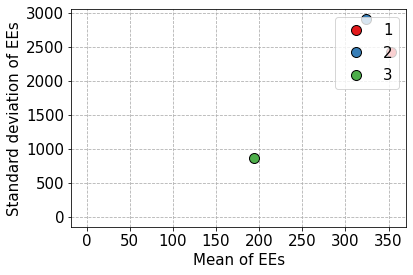

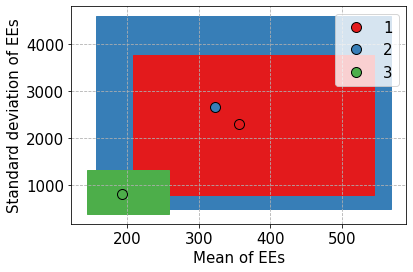

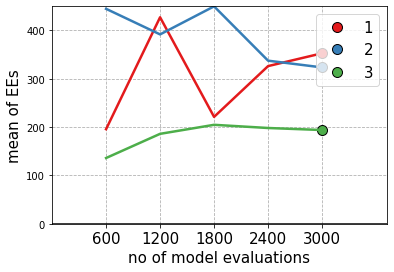

In [8]:
#%% Step 5 (Computation of the Elementary effects)
design_type = 'radial'
mi, sigma, _ = EET_indices(r, xmin, xmax, X, Y, design_type)

# Plot results in the plane (mean(EE), std(EE)):
EET_plot(mi, sigma, X_Labels)
plt.show()

# Use bootstrapping to derive confidence bounds:
Nboot = 1000
# Compute sensitivity indices for Nboot bootstrap resamples:
mi, sigma, EE = EET_indices(r, xmin, xmax, X, Y, design_type, Nboot=Nboot)
# mi and sigma have shape (Nboot, M)
# Compute mean and confidence intervals of the sensitivity indices across the
# bootstrap resamples:
mi_m, mi_lb, mi_ub = aggregate_boot(mi) # shape (M,)
sigma_m, sigma_lb, sigma_ub = aggregate_boot(sigma) # shape (M,)

# Plot bootstrapping results in the plane (mean(EE),std(EE)):
EET_plot(mi_m, sigma_m, X_Labels, mi_lb, mi_ub, sigma_lb, sigma_ub)
plt.show()

# Repeat computations using a decreasing number of samples so as to assess
# if convergence was reached within the available dataset:
rr = np.linspace(r/5, r, 5).astype(int) # Sample sizes at which the indices will
# be estimated
mic, sigmac = EET_convergence(EE, rr) # mic and sigmac are lists in which
# the i-th element correspond to the sensitivity indices at the i-th sample size
# Plot the sensitivity measure (mean of elementary effects) as a function
# of the number of model evaluations:
plt.figure()
pf.plot_convergence(mic, rr*(M+1), X_Label='no of model evaluations',
                    Y_Label='mean of EEs', labelinput=X_Labels)
plt.show()

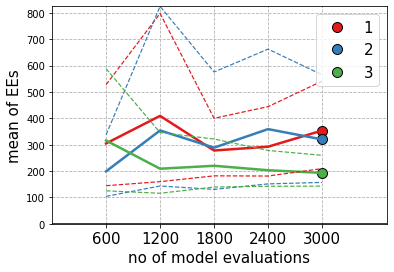

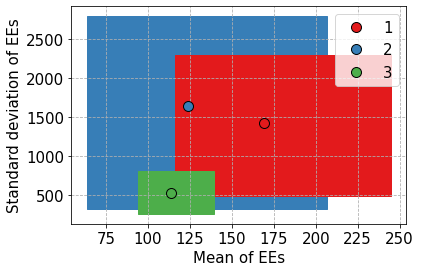

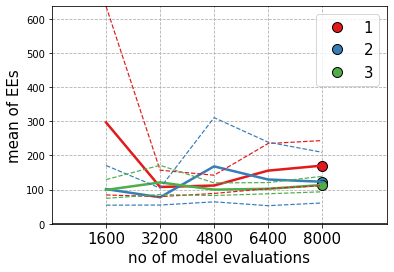

In [9]:
# Repeat convergence analysis using bootstrapping:
# Compute sensitivity indices for Nboot bootstrap resamples:
mic, sigmac = EET_convergence(EE, rr, Nboot) # mic and sigmac are lists in
# which the i-th element correspond to the sensitivity indices at the i-th sample size
# Compute mean and confidence intervals of the sensitivity indices across the
# bootstrap resamples:
mic_m, mic_lb, mic_ub = aggregate_boot(mic) # shape (R,M)
sigmac_m, sigmac_lb, sigmac_ub = aggregate_boot(sigmac) # shape (R,M)
# Plot the sensitivity measure (mean of elementary effects) as a function
# of the number of model evaluations:
plt.figure()
pf.plot_convergence(mic_m, rr*(M+1), mic_lb, mic_ub,
                    X_Label='no of model evaluations', Y_Label='mean of EEs',
                    labelinput=X_Labels)
plt.show()

#%% Step 6 (Adding up new samples)

# Add new parameter samples:
r2 = 2000 # New sample size
X2, Xnew = OAT_sampling_extend(X, r2, distr_fun, distr_par, design_type)
# extended sample (it includes the already evaluated sample 'X' and the new one)

# Evaluate model against the new sample:
Ynew = model_execution(fun_test, Xnew)
# Ynew = model_execution(fun_test, Xnew, rain, evap, flow, warmup) # shape((r2-r)*(M+1),1)

# Put new and old results together:
Y2 = np.concatenate((Y, Ynew)) # shape (r2*(M+1),1)

# Recompute indices:
Nboot = 1000
mi2, sigma2, EE2 = EET_indices(r2, xmin, xmax, X2, Y2, design_type, Nboot)
# Compute mean and confidence intervals of the sensitivity indices across the
# bootstrap resamples:
mi2_m, mi2_lb, mi2_ub = aggregate_boot(mi2) # shape (M,)
sigma2_m, sigma2_lb, sigma2_ub = aggregate_boot(sigma2) # shape (M,)
# Plot new bootstrapping results in the plane (mean(EE),std(EE)):
EET_plot(mi2_m, sigma2_m, X_Labels, mi2_lb, mi2_ub, sigma2_lb, sigma2_ub)
plt.show()

# Repeat convergence analysis:
Nboot = 1000
rr2 = np.linspace(r2/5, r2, 5).astype(int)
mic2, sigmac2 = EET_convergence(EE2, rr2, Nboot)
# Compute mean and confidence intervals of the sensitivity indices across the
# bootstrap resamples:
mic2_m, mic2_lb, mic2_ub = aggregate_boot(mic2) # shape (M,)
sigmac2_m, sigmac2_lb, sigmac2_ub = aggregate_boot(sigmac2) # shape (M,)
# Plot the sensitivity measure (mean of elementary effects) as a function
# of model evaluations:
plt.figure()
pf.plot_convergence(mic2_m, rr2*(M+1), mic2_lb, mic2_ub,
                    X_Label='no of model evaluations', Y_Label='mean of EEs',
                    labelinput=X_Labels)
plt.show()